In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/har25indoor/HARDATA_SHREYA/desktop.ini
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_161.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_206.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_153.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_102.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_002.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_012.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_134.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_052.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_148.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_136.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_165.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_041.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_205.jp

In [2]:
!pip install -q transformers datasets


In [3]:
from datasets import load_dataset
dataset = load_dataset("imagefolder", data_dir="/kaggle/input/har25indoor/HARDATA_SHREYA")

Resolving data files:   0%|          | 0/5480 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [4]:
train_ds = dataset['train']

In [5]:
splits = train_ds.train_test_split(test_size=0.15)
train_ds = splits['train']
val_ds = splits['test']

In [6]:
splits2 = train_ds.train_test_split(test_size=0.15)
train_ds = splits2['train']
test_ds = splits2['test']

In [7]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'Washing Dishes',
 1: 'applauding',
 2: 'brushing teeth',
 3: 'cleaning the floor',
 4: 'cooking',
 5: 'cutting veggies',
 6: 'dancing',
 7: 'drinking',
 8: 'eating',
 9: 'fighting',
 10: 'hugging',
 11: 'laughing',
 12: 'phoning',
 13: 'pouring a liquid',
 14: 'reading',
 15: 'sitting',
 16: 'sleeping',
 17: 'smoking',
 18: 'taking photos',
 19: 'texting',
 20: 'using a computer',
 21: 'watching tv',
 22: 'waving hands',
 23: 'writing on a board',
 24: 'writing on a book'}

In [8]:
from transformers import AutoImageProcessor

processor = AutoImageProcessor.from_pretrained("apple/mobilevit-small")

2024-08-24 19:18:49.289129: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-24 19:18:49.289235: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-24 19:18:49.452884: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

In [9]:
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)

# Define mean and std for normalization (example values)
image_mean = [0.485, 0.456, 0.406]  # Example mean for ImageNet
image_std = [0.229, 0.224, 0.225]   # Example std for ImageNet
size = 224  # Example size, you can adjust it as needed

normalize = Normalize(mean=image_mean, std=image_std)

_train_transforms = Compose(
    [
        RandomResizedCrop(size),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)

_val_transforms = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        normalize,
    ]
)

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples


In [10]:
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [11]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [12]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [13]:
from transformers import MobileViTForImageClassification

model = MobileViTForImageClassification.from_pretrained('apple/mobilevit-small',
                                                  id2label=id2label,
                                                  label2id=label2id,
                                                  ignore_mismatched_sizes = True)

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/22.5M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([25, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([25]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    output_dir='/kaggle/working/',
    run_name = "mobile_vit_training",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=15,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [15]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [16]:
import wandb

wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ······································································································································································································································································································································································································································································································································································································································································································································································································································································································································································································································

wandb: ERROR API key must be 40 characters long, yours was 2917
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [17]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [18]:
trainer.train()

wandb: Currently logged in as: sagnik-sengupta123 (sagniksengupta14). Use `wandb login --relogin` to force relogin


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.988064,0.342683
2,No log,2.465564,0.458537
3,No log,2.102702,0.460976
4,No log,1.850756,0.496341
5,No log,1.652100,0.528049
6,No log,1.572232,0.542683
7,No log,1.464373,0.579268
8,No log,1.395462,0.595122
9,2.277200,1.348079,0.613415
10,2.277200,1.289924,0.618293


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=930, training_loss=1.9505723522555443, metrics={'train_runtime': 655.0948, 'train_samples_per_second': 90.33, 'train_steps_per_second': 1.42, 'total_flos': 2.647480319221248e+17, 'train_loss': 1.9505723522555443, 'epoch': 15.0})

In [19]:
outputs = trainer.predict(test_ds)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [20]:
print(outputs.metrics)

{'test_loss': 1.2476376295089722, 'test_accuracy': 0.624103299856528, 'test_runtime': 6.7032, 'test_samples_per_second': 103.98, 'test_steps_per_second': 3.282}


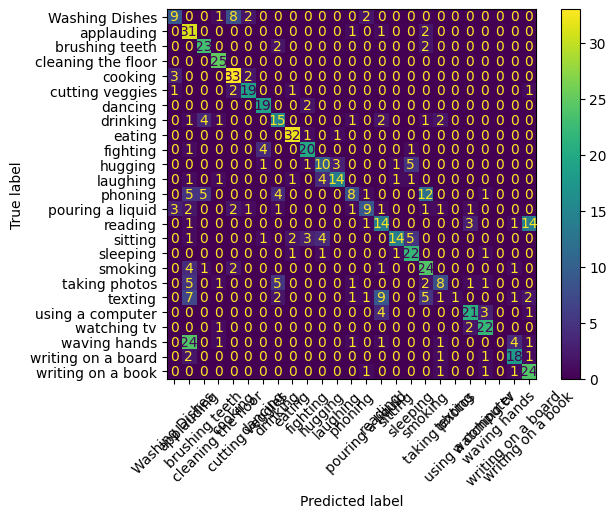

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.41      0.47        22
           1       0.36      0.89      0.52        35
           2       0.70      0.85      0.77        27
           3       0.81      1.00      0.89        25
           4       0.70      0.87      0.78        38
           5       0.79      0.79      0.79        24
           6       0.76      0.90      0.83        21
           7       0.52      0.56      0.54        27
           8       0.86      0.94      0.90        34
           9       0.74      0.77      0.75        26
          10       0.53      0.48      0.50        21
          11       0.78      0.61      0.68        23
          12       0.57      0.22      0.32        36
          13       0.60      0.39      0.47        23
          14       0.42      0.41      0.42        34
          15       0.82      0.47      0.60        30
          16       0.65      0.85      0.73        26
          17       0.49    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
trainer.save_model("/kaggle/working/mobile_vit_model")